<a href="https://colab.research.google.com/github/Lihini827/speech-emotion-hybridLSTM-RNn-gradcam/blob/main/2lstm_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
Crema = "/content/drive/MyDrive/speech emotion recognition/TESS Toronto emotional speech set data/"

In [ ]:
file_emotion = []
file_path = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/speech emotion recognition/TESS Toronto emotional speech set data'):
    for filename in filenames:
        file_path.append(os.path.join(dirname,filename))
        file_emotion.append(filename.split('_')[-1].split('.')[0].lower())
    if(len(file_emotion)==2800):
        break
print('Dataset is loaded')

Dataset is loaded


In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,sad,/content/drive/MyDrive/speech emotion recognit...
1,sad,/content/drive/MyDrive/speech emotion recognit...
2,sad,/content/drive/MyDrive/speech emotion recognit...
3,sad,/content/drive/MyDrive/speech emotion recognit...
4,sad,/content/drive/MyDrive/speech emotion recognit...


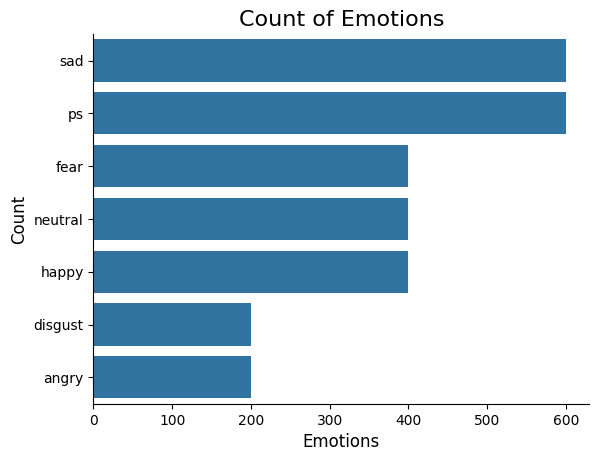

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
labels = {'sad':0,'ps':1,'fear':2,'neutral':3,'happy':4,'disgust':5,'angry':6}
Crema_df.replace({'Emotions':labels},inplace=True)

In [ ]:
import librosa

In [ ]:
num_mfcc=5
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": []
    }
for i in range(2800):
    data['labels'].append(Crema_df.iloc[i,0])
    signal, sample_rate = librosa.load(Crema_df.iloc[i,1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i%500==0:
        print(i)

0
500
1000
1500
2000
2500


In [ ]:
X = np.asarray(data['mfcc'])
y = np.asarray(data["labels"])

<ipython-input-21-702a30aa7d8e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(data['mfcc'])


In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(2800, 129, 5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(2016, 129, 5) (2016,) (504, 129, 5) (504,) (280, 129, 5) (280,)


In [ ]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(7, activation='softmax'))

    return model

In [ ]:
input_shape = (None,5)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 128)         68608     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 122631 (479.03 KB)
Trainable params: 122631 (479.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
63/63 [==============================] - 20s 245ms/step - loss: 1.4349 - accuracy: 0.4777 - val_loss: 0.7873 - val_accuracy: 0.6647
Epoch 2/30
63/63 [==============================] - 15s 235ms/step - loss: 0.5594 - accuracy: 0.8160 - val_loss: 0.3736 - val_accuracy: 0.8532
Epoch 3/30
63/63 [==============================] - 15s 232ms/step - loss: 0.3367 - accuracy: 0.8914 - val_loss: 0.2342 - val_accuracy: 0.9147
Epoch 4/30
63/63 [==============================] - 16s 250ms/step - loss: 0.3206 - accuracy: 0.8924 - val_loss: 0.1595 - val_accuracy: 0.9444
Epoch 5/30
63/63 [==============================] - 15s 234ms/step - loss: 0.2099 - accuracy: 0.9360 - val_loss: 0.1581 - val_accuracy: 0.9425
Epoch 6/30
63/63 [==============================] - 15s 232ms/step - loss: 0.2282 - accuracy: 0.9311 - val_loss: 0.2938 - val_accuracy: 0.9048
Epoch 7/30
63/63 [==============================] - 16s 259ms/step - loss: 0.5069 - accuracy: 0.8363 - val_loss: 0.2505 - val_accuracy: 0.9266

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.9857142567634583


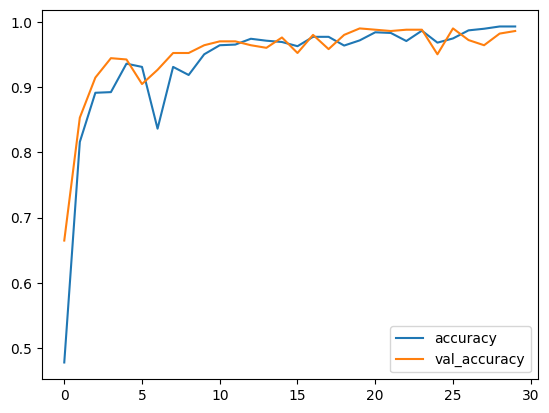

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

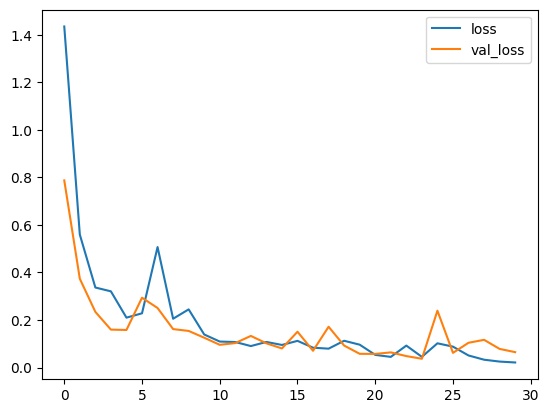

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()